In [1]:
from PIL import Image
from io import BytesIO
from IPython import display
import numpy as np

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

IMG_ROWS = 64
IMG_COLS = 64

data = np.load("../data/etl8.npz")['data']

In [3]:
import sklearn.model_selection
import keras

NUM_CLASSES = 956

# 150 ~ 159 for hyper parameters
alldata = data[0:150]
dataset_len = alldata.shape[0]

# flatten
x_all = alldata.reshape((dataset_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1))
x_all = x_all.astype(np.float32)
x_all /= 255
y_all = np.tile(np.arange(NUM_CLASSES), dataset_len)
y_all = keras.utils.to_categorical(y_all, NUM_CLASSES)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_all, y_all, test_size=0.1)

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator

input_shape = (IMG_ROWS, IMG_COLS, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

In [5]:
from keras.callbacks import Callback, EarlyStopping
datagen = ImageDataGenerator(
    rotation_range=12,
    zoom_range=[0.9, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="constant",
    cval=0.0
)
BATCH_SIZE = 32
steps = int(x_train.shape[0] / BATCH_SIZE)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=steps, epochs=50, verbose=True,
        callbacks=[EarlyStopping(patience=4)],
        validation_data=(x_test, y_test))

Epoch 1/20
4033/4033 [==============================] - 122s - loss: 6.5122 - acc: 0.0036 - val_loss: 5.4651 - val_acc: 0.0215
Epoch 2/20
4033/4033 [==============================] - 121s - loss: 4.5825 - acc: 0.0715 - val_loss: 2.5347 - val_acc: 0.3805
Epoch 3/20
4033/4033 [==============================] - 121s - loss: 2.8691 - acc: 0.2803 - val_loss: 1.0727 - val_acc: 0.7195
Epoch 4/20
4033/4033 [==============================] - 121s - loss: 1.8967 - acc: 0.4799 - val_loss: 0.5391 - val_acc: 0.8567
Epoch 5/20
4033/4033 [==============================] - 121s - loss: 1.3761 - acc: 0.6088 - val_loss: 0.3284 - val_acc: 0.9042
Epoch 6/20
4033/4033 [==============================] - 121s - loss: 1.0693 - acc: 0.6926 - val_loss: 0.2126 - val_acc: 0.9394
Epoch 7/20
4033/4033 [==============================] - 121s - loss: 0.8749 - acc: 0.7445 - val_loss: 0.1670 - val_acc: 0.9534
Epoch 8/20
4033/4033 [==============================] - 121s - loss: 0.7415 - acc: 0.7833 - val_loss: 0.1679 - 

In [6]:
score = model.predict(x_test)
# predicted = np.array([np.argmax(r) for r in score])
predicted = np.argmax(score, axis=1)

idx, val = np.where(y_test == 1)
ans = val[idx]

correct = np.where(predicted == ans)[0]
errors = np.where(predicted != ans)[0]

267
14073


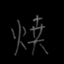

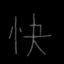

In [29]:
# print(len(errors))
# print(len(correct))
# e = errors[21]
# display_image((x_test[e] * 255).reshape(IMG_ROWS, IMG_COLS))
# display_image(data[0][predicted[e]])

In [30]:
model.save("../etl8_neru.h5")

In [33]:
evaldata = data[150:]
dataset_len = evaldata.shape[0]

# flatten
x_eval = evaldata.reshape((dataset_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1))
x_eval = x_eval.astype(np.float32)
x_eval /= 255
y_eval = np.tile(np.arange(NUM_CLASSES), dataset_len)
y_eval = keras.utils.to_categorical(y_eval, NUM_CLASSES)

model.evaluate(x_eval, y_eval)

9560/9560 [==============================] - 2s     


[0.037958197186410692, 0.9873430962343096]